In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
sentiment_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')

print("Sentiment Data Info:")
print(sentiment_df.info())
print("\nTrader Data Info:")
print(trader_df.info())

Sentiment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

Trader Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null 

In [5]:
# Standardize column names for easier access in the trader data
trader_df.rename(columns={
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Timestamp IST': 'timestamp_ist',
    'Closed PnL': 'closed_pnl',
    'Account': 'account',
    'Side': 'side'
}, inplace=True)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
trader_df['timestamp_ist'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M')

# Extract just the date for merging
sentiment_df['date_only'] = sentiment_df['date'].dt.date
trader_df['date_only'] = trader_df['timestamp_ist'].dt.date

print("\nCleaned and Preprocessed Data Info:")
print(sentiment_df.head())
print(trader_df.head())


Cleaned and Preprocessed Data Info:
    timestamp  value classification       date   date_only
0  1517463000     30           Fear 2018-02-01  2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02  2018-02-02
2  1517635800     40           Fear 2018-02-03  2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04  2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05  2018-02-05
                                      account  Coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    

In [6]:
# Merge the two dataframes on the date
merged_df = pd.merge(trader_df, sentiment_df, left_on='date_only', right_on='date_only', how='left')

merged_df = merged_df.drop('date_only', axis=1)
print("\nMerged Data Info:")
print(merged_df.info())


Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   execution_price   211224 non-null  float64       
 3   size_tokens       211224 non-null  float64       
 4   size_usd          211224 non-null  float64       
 5   side              211224 non-null  object        
 6   timestamp_ist     211224 non-null  datetime64[ns]
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   closed_pnl        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null  float

In [7]:
# Aggregate daily PnL and other metrics
daily_performance = merged_df.groupby(merged_df['date']).agg(
    total_pnl=('closed_pnl', 'sum'),
    total_volume_usd=('size_usd', 'sum'),
    sentiment_score=('value', 'first')
).reset_index()

# Correlation Analysis, excluding the 'leverage' column
correlation_matrix = daily_performance[['total_pnl', 'total_volume_usd', 'sentiment_score']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                  total_pnl  total_volume_usd  sentiment_score
total_pnl          1.000000          0.325759        -0.082642
total_volume_usd   0.325759          1.000000        -0.264371
sentiment_score   -0.082642         -0.264371         1.000000


In [8]:
# Aggregate daily PnL and other metrics
daily_performance = merged_df.groupby(merged_df['date']).agg(
    total_pnl=('closed_pnl', 'sum'),
    total_volume_usd=('size_usd', 'sum'),
    sentiment_score=('value', 'first')
).reset_index()

# Correlation Analysis, excluding the 'leverage' column
correlation_matrix = daily_performance[['total_pnl', 'total_volume_usd', 'sentiment_score']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                  total_pnl  total_volume_usd  sentiment_score
total_pnl          1.000000          0.325759        -0.082642
total_volume_usd   0.325759          1.000000        -0.264371
sentiment_score   -0.082642         -0.264371         1.000000


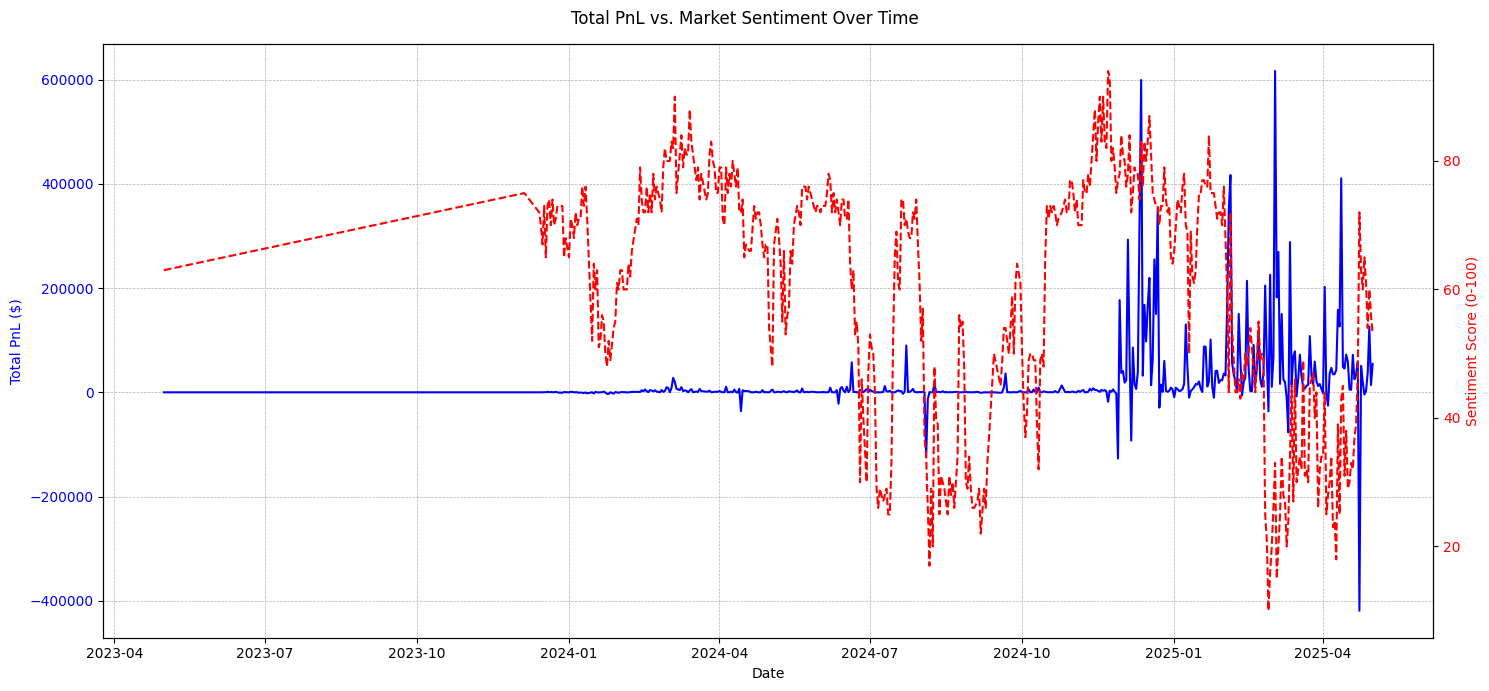

In [9]:
# Plotting PnL and Sentiment Score over time
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot PnL on the primary y-axis
ax1.plot(daily_performance['date'], daily_performance['total_pnl'], color='blue', label='Total PnL')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total PnL ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a secondary y-axis for Sentiment Score
ax2 = ax1.twinx()
ax2.plot(daily_performance['date'], daily_performance['sentiment_score'], color='red', linestyle='--', label='Sentiment Score')
ax2.set_ylabel('Sentiment Score (0-100)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Total PnL vs. Market Sentiment Over Time')
fig.tight_layout()
plt.savefig('pnl_vs_sentiment_time_series.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

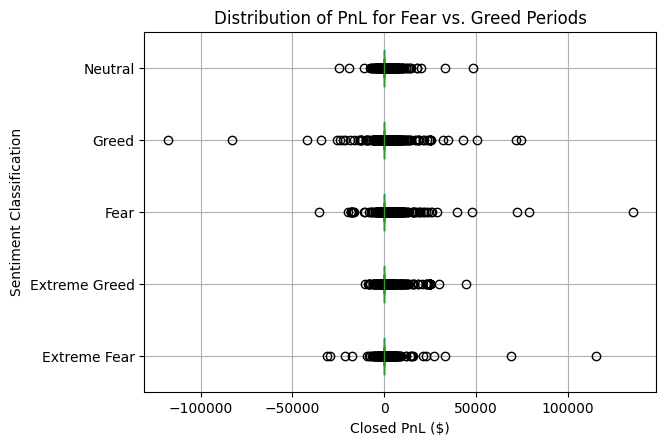

In [10]:
# Box plot to compare PnL distribution during Fear vs Greed
merged_df['sentiment_class'] = merged_df['classification'].fillna('Neutral')

plt.figure(figsize=(10, 6))
merged_df.boxplot(column='closed_pnl', by='sentiment_class', vert=False, grid=True)
plt.title('Distribution of PnL for Fear vs. Greed Periods')
plt.xlabel('Closed PnL ($)')
plt.ylabel('Sentiment Classification')
plt.suptitle("") # Suppress default title
plt.savefig('pnl_distribution_by_sentiment.png')
plt.show()

In [11]:
# Group by 'account' and calculate total PnL
trader_summary = merged_df.groupby('account')['closed_pnl'].sum().reset_index()

# Identify top 10% and bottom 10% traders
top_10_percent_pnl = trader_summary['closed_pnl'].quantile(0.9)
bottom_10_percent_pnl = trader_summary['closed_pnl'].quantile(0.1)

successful_traders = trader_summary[trader_summary['closed_pnl'] >= top_10_percent_pnl]['account']
unsuccessful_traders = trader_summary[trader_summary['closed_pnl'] <= bottom_10_percent_pnl]['account']

# Filter the merged data for these groups
successful_trades = merged_df[merged_df['account'].isin(successful_traders)]
unsuccessful_trades = merged_df[merged_df['account'].isin(unsuccessful_traders)]

# Analyze their behavior during different sentiment periods
successful_behavior = successful_trades.groupby('classification')['side'].value_counts(normalize=True).unstack()
unsuccessful_behavior = unsuccessful_trades.groupby('classification')['side'].value_counts(normalize=True).unstack()

print("\nSuccessful Traders' Actions by Sentiment:")
print(successful_behavior)
print("\nUnsuccessful Traders' Actions by Sentiment:")
print(unsuccessful_behavior)


Successful Traders' Actions by Sentiment:
side                 BUY      SELL
classification                    
Extreme Fear    0.582524  0.417476
Extreme Greed   0.338670  0.661330
Fear            0.501918  0.498082
Greed           0.489053  0.510947
Neutral         0.503235  0.496765

Unsuccessful Traders' Actions by Sentiment:
side                 BUY      SELL
classification                    
Extreme Fear    0.482854  0.517146
Extreme Greed   0.443272  0.556728
Fear            0.356742  0.643258
Greed           0.686175  0.313825
Neutral         0.309730  0.690270
